## _*LiH dissociation curve using NumPyMinimumEigensolver*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy and dipole moments of a Lithium Hydride (LiH) molecule over a range of inter-atomic distances.

This notebook has been written to use the PYSCF chemistry driver.

Note: In order to allow this to run reasonably quickly it takes advantage of the ability to freeze core orbitals to reduce the size of the problem.

In [10]:
import numpy as np
import pylab

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_algorithms import NumPyMinimumEigensolver

from qiskit_algorithms.optimizers import SLSQP

from qiskit.circuit.library import TwoLocal
from qiskit_algorithms import VQE
from qiskit.primitives import Estimator

In [23]:
algorithms = ['NumPyMinimumEigensolver', 'VQE']

distances  = [x * 0.1  for x in range(6, 20)]
distances += [x * 0.25 for x in range(8, 17)]

In [41]:
def compute_energies(algorithm, distances):
    print(f'{algorithm}, processing step __', end='')

    energies = []
    hf_energies = []
    estimator = Estimator()

    for i, d in enumerate(distances):
        print('\b\b{:2d}'.format(i), end='', flush=True)

        info = MoleculeInfo(["Li", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, d)])
        driver = PySCFDriver.from_molecule(info, basis="sto3g")
        molecule = driver.run()
        transformer = FreezeCoreTransformer()
        molecule = transformer.transform(molecule)
        hamiltonian = molecule.hamiltonian.second_q_op()
        mapper = ParityMapper(num_particles=molecule.num_particles)
        tapered_mapper = molecule.get_tapered_mapper(mapper)
        qubit_op = tapered_mapper.map(hamiltonian)

        if algorithm == 'NumPyMinimumEigensolver':
            algo = NumPyMinimumEigensolver()
            algo.filter_criterion = molecule.get_default_filter_criterion()
            solver = GroundStateEigensolver(mapper, algo)
            result = solver.solve(molecule)
            hf_energies.append(result.hartree_fock_energy)
            energies.append(result.total_energies[0])

        elif algorithm == 'VQE':
            optimizer = SLSQP(maxiter=10000, ftol=1e-9)
            ansatz = TwoLocal(qubit_op.num_qubits, ['ry', 'rz'], 'cz', 'linear', reps=2)
            vqe = VQE(estimator, ansatz, optimizer)
            vqe.initial_point = [0] * ansatz.num_parameters
            algo = GroundStateEigensolver(tapered_mapper, vqe)
            result = algo.solve(molecule)
            energies.append(result.total_energies[0])

    print(' --- complete')
    return hf_energies, energies


In [21]:
estimator = Estimator()
info = MoleculeInfo(["Li", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, 1.5)])
driver = PySCFDriver.from_molecule(info, basis="sto3g")
molecule = driver.run()
transformer = FreezeCoreTransformer()
molecule = transformer.transform(molecule)
hamiltonian = molecule.hamiltonian.second_q_op()
mapper = ParityMapper(num_particles=molecule.num_particles)
tapered_mapper = molecule.get_tapered_mapper(mapper)
qubit_op = tapered_mapper.map(hamiltonian)
optimizer = SLSQP(maxiter=1000, ftol=1e-6)
ansatz = TwoLocal(qubit_op.num_qubits, ['ry', 'rz'], 'cz', 'linear', reps=2)
vqe = VQE(estimator, ansatz, optimizer)
vqe.initial_point = [0] * ansatz.num_parameters
algorithm = GroundStateEigensolver(tapered_mapper, vqe)
result = algorithm.solve(molecule)
electronic_structure_result.total_energies[0]

np.float64(-7.86519934592008)

In [36]:
hf_energies, npme_energies = compute_energies(algorithms[0], distances)

NumPyMinimumEigensolver, processing step 22 --- complete


In [42]:
_, vqe_energies = compute_energies(algorithms[1], distances) # this takes a while

VQE, processing step 22 --- complete


In [43]:
print(f'HF bond distance: {distances[hf_energies.index(min(hf_energies))]} A\nVQE bond distance: {distances[vqe_energies.index(min(vqe_energies))]} A\nNumpyMinimumEigensolver bond distance: {distances[npme_energies.index(min(npme_energies))]} A\n')

HF bond distance: 1.5 A
VQE bond distance: 1.5 A
NumpyMinimumEigensolver bond distance: 1.5 A



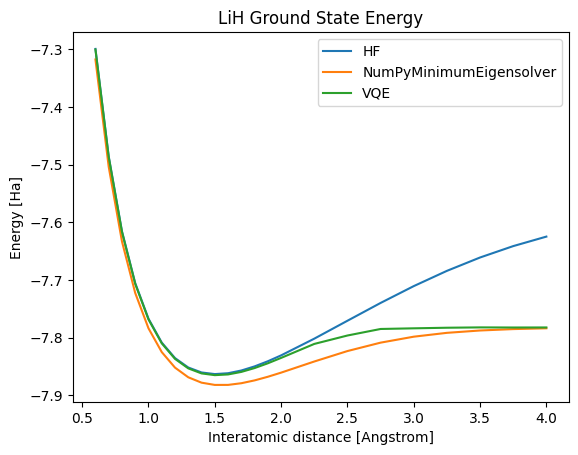

In [45]:
pylab.plot(distances, hf_energies, label='HF')
pylab.plot(distances, npme_energies, label=algorithms[0])
pylab.plot(distances, vqe_energies, label=algorithms[1])
pylab.xlabel('Interatomic distance [Angstrom]')
pylab.ylabel('Energy [Ha]')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right')